# Import libraries

In [1]:
import numpy as np
import numpy.ma as ma
import xarray as xr
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow
import io
import os
from PIL import Image

import tensorflow as tf
import tensorflow.math
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Masking

from tensorflow.keras.utils import to_categorical


plt.rcParams['figure.figsize'] = (12,12)

# Load MAR output

#### Load local MAR output for 2020 on 6.5km

In [2]:
ds = xr.open_dataset('/Users/raf/Documents/Columbia/Research/Albedo/Data/MAR/MARv3.12-6_5km-daily-ERA5-2020.nc')

#### Load bare ice variable (from Antwerpen et al., 2022). This variables gives 1's for bare ice and NaNs for non-bare ice (snow, land, or ocean) daily for June, July, and August in 2000-2021

In [3]:
ds_bie = sio.loadmat('/Users/raf/Documents/Columbia/Research/Albedo/Data/sboth_6km.mat')

#### Flip matrix right-side up and change dimension order

In [4]:
bareice = np.flipud(ds_bie['sboth_6km'])
bareice = np.transpose(bareice, (3, 0, 1, 2))

#### Load variables from MAR for June, July, and August in 2020 and place them in new variable 'x'. Variables loaded: surface temperature (ST2), liquid water content (WA1), shortwave radiation up/down (SWU/SWD), longwave radiation up/down (LWU/LWD), sensible heat flux (SHF), latent heat flux (LHF), x-wind speed component (UU), y-wind speed component (VV), surface pressure (SP), sublimation from snow/soil (SU), snowfall (SF), rainfall (RF), cloud cover up/middle/down (CU/CM/CD), cloud optical depth (COD), density (RO1), surface height (SH), soil type (SOL)

In [5]:
# this is just for 2020
jun1 = 152
aug31 = 243
numberdays = aug31-jun1+1

n_feature = 21
n_lat = 415
n_lon = 230

x = np.zeros((numberdays, n_lat, n_lon, n_feature))

x[:,:,:,0] = ds.ST2.values[jun1:aug31+1,0,:,:]
x[:,:,:,1] = np.mean(ds.WA1.values[jun1:aug31+1,0:9,:,:], 1) # average of top 1m
x[:,:,:,2] = ds.SWU.values[jun1:aug31+1,:,:]
x[:,:,:,3] = ds.SWD.values[jun1:aug31+1,:,:]
x[:,:,:,4] = ds.LWU.values[jun1:aug31+1,:,:]
x[:,:,:,5] = ds.LWD.values[jun1:aug31+1,:,:]
x[:,:,:,6] = ds.SHF.values[jun1:aug31+1,:,:]
x[:,:,:,7] = ds.LHF.values[jun1:aug31+1,:,:]
x[:,:,:,8] = ds.UU.values[jun1:aug31+1,0,:,:]
x[:,:,:,9] = ds.VV.values[jun1:aug31+1,0,:,:]
x[:,:,:,10] = ds.SP.values[jun1:aug31+1,:,:]
x[:,:,:,11] = ds.SU.values[jun1:aug31+1,0,:,:]
x[:,:,:,12] = ds.SF.values[jun1:aug31+1,:,:]
x[:,:,:,13] = ds.RF.values[jun1:aug31+1,:,:]
x[:,:,:,14] = ds.CU.values[jun1:aug31+1,:,:]
x[:,:,:,15] = ds.CM.values[jun1:aug31+1,:,:]
x[:,:,:,16] = ds.CD.values[jun1:aug31+1,:,:]
x[:,:,:,17] = ds.COD.values[jun1:aug31+1,:,:]
x[:,:,:,18] = np.mean(ds.RO1.values[jun1:aug31+1,0:9,:,:], 1) # average of top 1m

# repeat the same data for each day for surface height (SH) and soil type (SOL) since they do not vary temporally.
for i in range(aug31-jun1+1):
    x[i,:,:,19] = ds.SH.values
    x[i,:,:,20] = ds.SOL.values

# Load MODIS albedo data

#### Load MODIS albedo data for June, July, and August in 2020

In [6]:
path = '/Users/raf/Documents/Columbia/Research/Albedo/Data/MOD10A1_albedo_MARproj_6_5km/'
dir_list = np.sort(os.listdir(path))
dir_list = dir_list[1825:1917]

#### Flip matrix right-side up and place in new matrix 'y'

In [7]:
y = np.zeros((92,415,230,1))

for i in range (0,len(dir_list)):
    f = dir_list[i]
    im = Image.open(path + f)
    y[i,:,:,0] = np.flipud(np.array(im))

#### Turn 255's into NaNs, divide by 100 to get albedo in 0-1 range, and multiply with bare ice matrix to extract only bare ice albedo values

In [8]:
y = np.where(y == 255, np.nan, y)
y = y/100
y = y[:,:,:,0] * bareice[:,:,:,20]

# Only run if using albedo difference between MODIS and MAR

#### Subtract MAR albedo (AL2) from MODIS albedo to set the predictant as the albedo difference between MODIS and MAR

In [125]:
y = y - ds.AL2.values[jun1:aug31+1,0,:,:]

# Only run if using SW quadrant

In [9]:
n_lat = int(n_lat/2)
n_lon = 100

x = x[:,:n_lat,:n_lon,:]
y = y[:,:n_lat,:n_lon]

# Prepare data for training and testing

#### Split data into training (80%) and testing (20%). Split at 80% of the time series, don't shuffle the data

In [10]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((73, 207, 100, 21), (19, 207, 100, 21), (73, 207, 100), (19, 207, 100))

#### Standardize the data so all values are in the 0-range, plusminus a couple (2-5).

In [12]:
X_train_dum = np.zeros((X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3]))
X_test_dum = np.zeros((X_test.shape[0], X_test.shape[1], X_test.shape[2], X_test.shape[3]))
for i in range(X_train.shape[3]):
    
    mean, std = np.nanmean(X_train[:,:,:,i]), np.nanstd(X_train[:,:,:,i])
        
    X_train_dum[:,:,:,i]   = (X_train[:,:,:,i] - mean)/std
    X_test_dum[:,:,:,i]    = (X_test[:,:,:,i] - mean)/std

X_train = X_train_dum
X_test = X_test_dum

#### Replace NaNs in output with arbitrary -10's. This is so the custom loss function can ignore these non-bare ice pixels

In [13]:
y_train = np.where(np.isnan(y_train), -10, y_train)
y_test = np.where(np.isnan(y_test), -10, y_test)

In [14]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((73, 207, 100, 21), (73, 207, 100), (19, 207, 100, 21), (19, 207, 100))

#### Add dummy dimension of size 1 in dimension number 1 to X_train and X_test. This is so the CNN-LSTM can work with the data

In [15]:
X_train_dum = np.zeros((X_train.shape[0], 1, X_train.shape[1], X_train.shape[2], X_train.shape[3]))
X_train_dum[:,0,:,:,:] = X_train
X_train = X_train_dum

X_test_dum = np.zeros((X_test.shape[0], 1, X_test.shape[1], X_test.shape[2], X_test.shape[3]))
X_test_dum[:,0,:,:,:] = X_test
X_test = X_test_dum

In [16]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((73, 1, 207, 100, 21), (73, 207, 100), (19, 1, 207, 100, 21), (19, 207, 100))

# Initialize and run CNN-LSTM model

#### Define custom loss function. This is a regular mean squared error (MSE) loss function. But it will only return a value when the predictant (MODIS albed) is not -10, so the CNN-LSTM will only train on the bare ice pixels and ignore the other pixels

In [17]:
def my_loss_fn(y_true, y_pred):
    
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    y_true_mask = tf.cast(tf.where(y_true > -9, 1, 0), dtype=tf.float32)
    squared_difference = tf.multiply(tf.square(y_true - y_pred), y_true_mask) / tf.math.reduce_sum(y_true_mask)
    
    return tf.reduce_mean(squared_difference, axis=-1)
#     return squared_difference

#### Set hyperparameters for CNN-LSTM

In [18]:
n_filters      = 20 # number of filters
kernel_size    = 3  # kernel size for convolutional layers
pool_size      = 2  # size for average pooling layers
n_lstm_unit    = 25 # number of LSTM units

activation     = 'relu' # activation function
learning_rate  = 100 # learning rate
minibatch_size = 100   # batch size
num_epochs     = 50   # number of total epochs

#### Set up CNN-LSTM model

In [19]:
model = Sequential()

model.add(Input(shape=(1, n_lat, n_lon, n_feature)))

model.add(TimeDistributed(Conv2D(n_filters, (kernel_size, kernel_size), 
                                     padding='same', activation=activation), input_shape=(1, n_lat, n_lon, n_feature)))

model.add(TimeDistributed(AveragePooling2D(pool_size)))
model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(LSTM(n_lstm_unit, activation=activation))

model.add(Dense(n_lat*n_lon))
model.add(Activation('linear'))
model.add(Reshape((1, n_lat, n_lon)))

model.compile(loss=my_loss_fn, optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)) #, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 1, 207, 100, 20)  3800      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 103, 50, 20)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 1, 20)            0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 25)                4600      
                                                                 
 dense (Dense)               (None, 20700)             538200    
                                                        

2022-12-21 08:17:24.686534: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Fit CNN-LSTM model

In [20]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(X_train, y_train, 
                    batch_size = minibatch_size,
                    epochs = num_epochs,
                    verbose=1,
                    callbacks=[early_stop],
                    validation_data =(X_test, y_test))

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 1.2457e-07 - val_loss: 4.5585e-07
Epoch 2/50
1/1 [==============================] - 1s 852ms/step - loss: 1.1127e-07 - val_loss: 4.1624e-07
Epoch 3/50
1/1 [==============================] - 1s 841ms/step - loss: 9.4722e-08 - val_loss: 3.7259e-07
Epoch 4/50
1/1 [==============================] - 1s 840ms/step - loss: 7.7095e-08 - val_loss: 3.2519e-07
Epoch 5/50
1/1 [==============================] - 1s 837ms/step - loss: 5.9021e-08 - val_loss: 2.6949e-07
Epoch 6/50
1/1 [==============================] - 1s 845ms/step - loss: 3.9946e-08 - val_loss: 2.2596e-07
Epoch 7/50
1/1 [==============================] - 1s 841ms/step - loss: 2.9658e-08 - val_loss: 2.1911e-07
Epoch 8/50
1/1 [==============================] - 1s 840ms/step - loss: 3.1195e-08 - val_loss: 1.9186e-07
Epoch 9/50
1/1 [==============================] - 1s 845ms/step - loss: 1.9625e-08 - val_loss: 1.9430e-07
Epoch 10/50
1/1 [==============================] 

#### Summarize history for loss

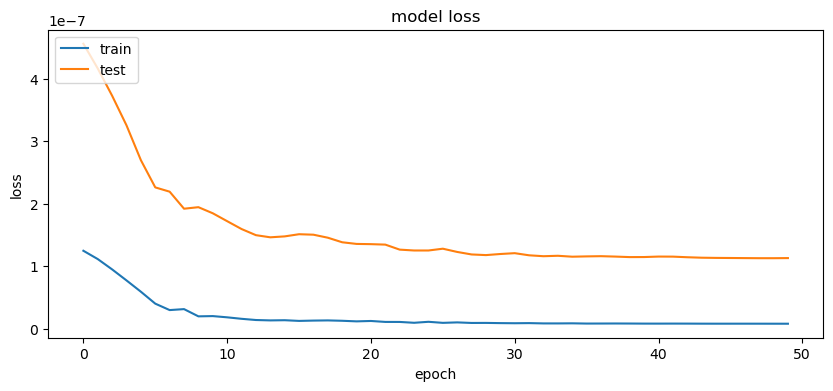

In [21]:
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Calculate CNN-LSTM albedo predictions

In [22]:
y_test_pred = model.predict(X_test)
y_test_pred = y_test_pred.reshape(y_test_pred.shape[0], X_train.shape[2], X_train.shape[3])

#### Turn non-bare ice pixels from -10's back into NaNs. This is for visualization

In [23]:
y_test_pred = np.where(y_test == -10, np.nan, y_test_pred)
y_test = np.where(y_test == -10, np.nan, y_test)

# Visualization

#### Map plots of observed ice albedo (left), predicted ice albedo (middle), and their difference (right)

/var/folders/8k/08rh6cnn3vl7qbdbxrryy07w0000gn/T/ipykernel_9770/2438035340.py:6: RuntimeWarning: Mean of empty slice
  p1 = ax1.pcolor(ds.LON.values[:n_lat,:n_lon], ds.LAT.values[:n_lat,:n_lon], np.nanmean(y_test, 0), cmap=cmap, vmin=0, vmax=1, zorder=2)
/var/folders/8k/08rh6cnn3vl7qbdbxrryy07w0000gn/T/ipykernel_9770/2438035340.py:6: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  p1 = ax1.pcolor(ds.LON.values[:n_lat,:n_lon], ds.LAT.values[:n_lat,:n_lon], np.nanmean(y_test, 0), cmap=cmap, vmin=0, vmax=1, zorder=2)
/var/folders/8k/08rh6cnn3vl7qbdbxrryy07w0000gn/T/ipykernel_9770/2438035340.py:17: RuntimeWarning: Mean of empty slice
  p2 = ax2.pcolor(ds.LON.values[:n_lat,:n_lon], ds.LAT.values[:n_lat,:n_lon], np.nanmean(y_test_pred, 0), cmap=cmap, vmin=0, vmax=1, zorder=2)
/var/folders/8k/08rh6cn

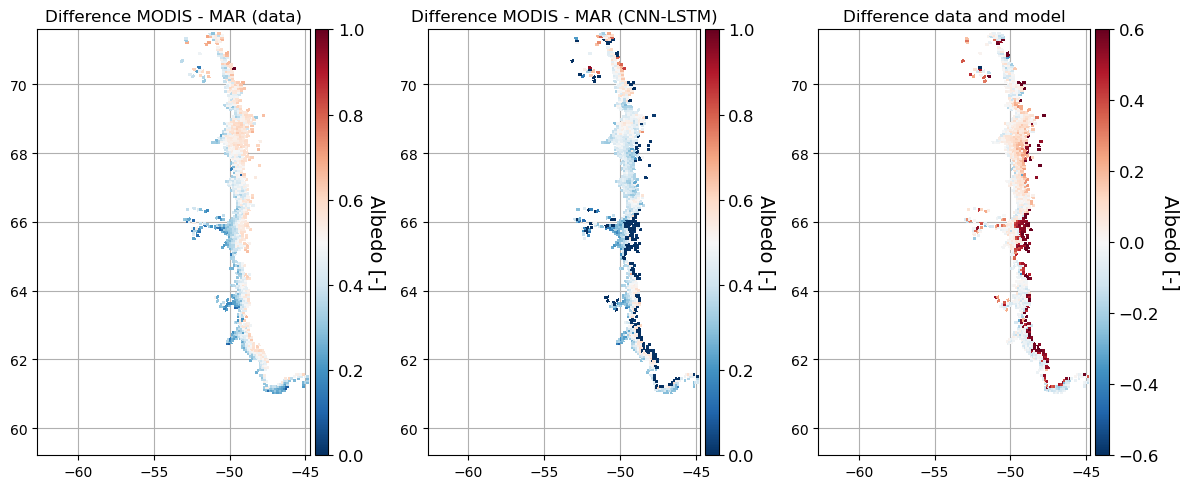

In [25]:
fig = plt.figure(figsize=(12, 5))

cmap = 'RdBu_r'

ax1 = fig.add_subplot(131)
p1 = ax1.pcolor(ds.LON.values[:n_lat,:n_lon], ds.LAT.values[:n_lat,:n_lon], np.nanmean(y_test, 0), cmap=cmap, vmin=0, vmax=1, zorder=2)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar1 = fig.colorbar(p1, cax=cax, orientation='vertical')
cbar1.set_label('Albedo [-]', rotation=270, fontsize=14)
cbar1.ax.tick_params(labelsize=12)
cbar1.ax.get_yaxis().labelpad = 15
ax1.grid(zorder=1)
ax1.set_title('Difference MODIS - MAR (data)')

ax2 = fig.add_subplot(132)
p2 = ax2.pcolor(ds.LON.values[:n_lat,:n_lon], ds.LAT.values[:n_lat,:n_lon], np.nanmean(y_test_pred, 0), cmap=cmap, vmin=0, vmax=1, zorder=2)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar2 = fig.colorbar(p2, cax=cax, orientation='vertical')
cbar2.set_label('Albedo [-]', rotation=270, fontsize=14)
cbar2.ax.tick_params(labelsize=12)
cbar2.ax.get_yaxis().labelpad = 15
ax2.grid(zorder=1)
ax2.set_title('Difference MODIS - MAR (CNN-LSTM)')

ax3 = fig.add_subplot(133)
p3 = ax3.pcolor(ds.LON.values[:n_lat,:n_lon], ds.LAT.values[:n_lat,:n_lon], np.nanmean(y_test, 0) - np.nanmean(y_test_pred, 0), cmap=cmap, vmin=-0.6 ,vmax=0.6, zorder=2)
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar3 = fig.colorbar(p3, cax=cax, orientation='vertical')
cbar3.set_label('Albedo [-]', rotation=270, fontsize=14)
cbar3.ax.tick_params(labelsize=12)
cbar3.ax.get_yaxis().labelpad = 15
ax3.grid(zorder=1)
ax3.set_title('Difference data and model')

plt.tight_layout()

#### MSE of MODIS and CNN-LSTM albedo

In [27]:
MSE1 = (np.nansum((np.nanmean(y_test, 0) - np.nanmean(y_test_pred, 0))**2)) / np.sum(~np.isnan(np.nanmean(y_test, 0)))
MSE1

/var/folders/8k/08rh6cnn3vl7qbdbxrryy07w0000gn/T/ipykernel_9770/1480134688.py:1: RuntimeWarning: Mean of empty slice
  MSE1 = (np.nansum((np.nanmean(y_test, 0) - np.nanmean(y_test_pred, 0))**2)) / np.sum(~np.isnan(np.nanmean(y_test, 0)))


0.05381334790006354

#### MSE of MODIS and MAR albedo

In [28]:
MSE2 = (np.nansum((np.nanmean(y_test, 0) - (np.nanmean(ds.AL2.values[aug31-18:aug31+1,0,:n_lat,:n_lon], 0) * np.where(np.nanmean(y_test[:,:n_lat,:n_lon], 0) > -8, 1, np.nan)))**2)) / np.sum(~np.isnan(np.nanmean(y_test, 0)))
MSE2

/var/folders/8k/08rh6cnn3vl7qbdbxrryy07w0000gn/T/ipykernel_9770/3693985743.py:1: RuntimeWarning: Mean of empty slice
  MSE2 = (np.nansum((np.nanmean(y_test, 0) - (np.nanmean(ds.AL2.values[aug31-18:aug31+1,0,:n_lat,:n_lon], 0) * np.where(np.nanmean(y_test[:,:n_lat,:n_lon], 0) > -8, 1, np.nan)))**2)) / np.sum(~np.isnan(np.nanmean(y_test, 0)))


0.034526004988395705

#### Scatterplot of MODIS and CNN-LSTM albedo

(0.0, 0.8)

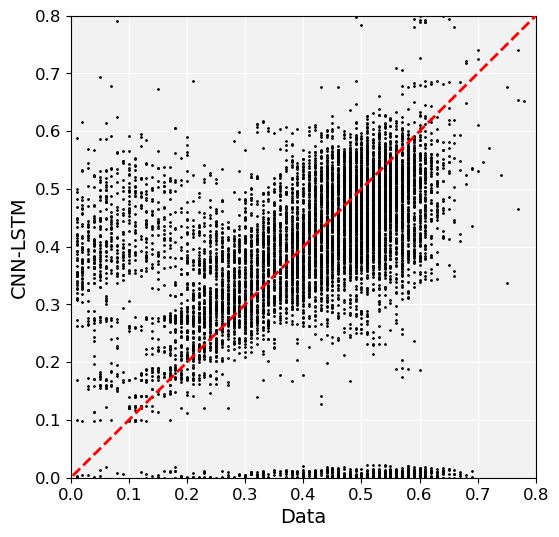

In [29]:
fig = plt.figure(figsize=(6,6))
ax = plt.gca()

plt.plot(np.arange(-1,1,0.1), np.arange(-1,1,0.1), 'r--', linewidth=2, zorder=3)
plt.scatter(y_test, y_test_pred, s=1, color='k', zorder=2)
plt.xlabel('Data', fontsize=14)
plt.ylabel('CNN-LSTM', fontsize=14)
plt.grid(color='w', zorder=1)
ax.set_facecolor([0.95, 0.95, 0.95])
plt.tick_params(labelsize=12)
plt.xlim(0, 0.8)
plt.ylim(0, 0.8)


#### R^2 between observed and predicted ice albedo

In [ ]:
corr2 = ma.corrcoef(ma.masked_invalid(y_test.flatten()), ma.masked_invalid(y_test_pred.flatten()))[1,0]**2
corr2

#### MSE and RMSE of observed and predicted ice albedo

In [32]:
MSE = np.nanmean((y_test - y_test_pred)**2)

RMSE = np.sqrt(MSE)

MSE, RMSE

(0.04440234517033096, 0.21071863982650174)

#### Calculation and map plot of average R^2 per pixel in the study domain

In [33]:
corr = np.zeros((n_lat, n_lon))
for i in range(n_lat):
    for j in range(n_lon):
        corr[i,j] = ma.corrcoef(ma.masked_invalid(y_test[:,i,j]), ma.masked_invalid(y_test_pred[:,i,j]))[1,0]

corr = corr**2

/var/folders/8k/08rh6cnn3vl7qbdbxrryy07w0000gn/T/ipykernel_9770/862558472.py:4: UserWarning: Warning: converting a masked element to nan.
  corr[i,j] = ma.corrcoef(ma.masked_invalid(y_test[:,i,j]), ma.masked_invalid(y_test_pred[:,i,j]))[1,0]


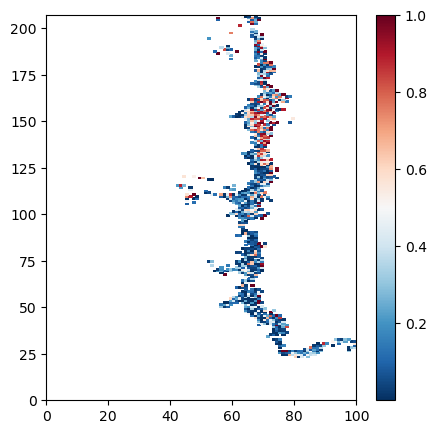

In [34]:
plt.figure(figsize=(5,5))
plt.pcolor(corr, cmap=cmap)
plt.colorbar()

#### Calculation and time series plot of R^2 averaged over the study domain

In [35]:
corr3 = np.zeros((19,1))

for i in range(19):
    corr3[i] = ma.corrcoef(ma.masked_invalid(y_test[i,:,:].flatten()), ma.masked_invalid(y_test_pred[i,:,:].flatten()))[1,0]**2
    

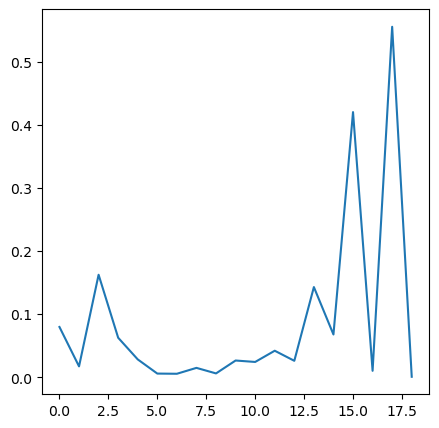

In [36]:
plt.figure(figsize=(5,5))
plt.plot(corr3)